In [62]:
import pandas as pd
import datetime
from my_pysyncon import Dataprep, Synth, AugSynth

In [63]:
df_mo = pd.read_csv('../../../Dataset_Generation/Jared/Data/total_state_data.csv')
df_mo['co2_per_capita'] = df_mo['monthly_emissions'] / df_mo['monthly_population']
df_mo['gdp_per_capita'] = df_mo['gdp_rel_2017_interp'] / df_mo['monthly_population']
df_mo['eprod_per_capita'] = df_mo['monthly_energy_prod'] / df_mo['monthly_population']
df_mo['eflow_per_capita'] = df_mo['monthly_energy_flow'] / df_mo['monthly_population']

df_yr = pd.read_csv('../../../Dataset_Generation/Jared/Data/yearly_total_data.csv')
df_yr['co2_per_capita'] = df_yr['total_co2'] / df_yr['yearly_population']
df_yr['gdp_per_capita'] = df_yr['yearly_gdp_rel_2017'] / df_yr['yearly_population']
df_yr['eprod_per_capita'] = df_yr['yearly_energy_prod'] / df_yr['yearly_population']
df_yr['eflow_per_capita'] = df_yr['yearly_energy_flow'] / df_yr['yearly_population']

In [64]:
df_mo.head(30)

,state,date,monthly_population,yearly_population,year,month,monthly_emissions,prcp,snow,tavg,...,monthly_energy_prod,monthly_energy_use,yearly_energy_prod,yearly_energy_use,monthly_energy_flow,yearly_energy_flow,co2_per_capita,gdp_per_capita,eprod_per_capita,eflow_per_capita
0,AL,1990-01-01,NaN,4050055.0,1990,1,4.698354e+06,7.89,0.0,46.8,...,105656.194444,136305.194444,1269484.0,1599432.0,-30649.000000,-329948.0,NaN,NaN,NaN,NaN
1,AL,1990-02-01,NaN,4050055.0,1990,2,4.077255e+06,9.35,0.0,51.9,...,105668.388889,136030.722222,1269484.0,1599432.0,-30362.333333,-329948.0,NaN,NaN,NaN,NaN
2,AL,1990-03-01,NaN,4050055.0,1990,3,4.167678e+06,8.92,0.0,54.2,...,105680.583333,135756.250000,1269484.0,1599432.0,-30075.666667,-329948.0,NaN,NaN,NaN,NaN
3,AL,1990-04-01,NaN,4050055.0,1990,4,3.828220e+06,4.48,0.0,59.7,...,105692.777778,135481.777778,1269484.0,1599432.0,-29789.000000,-329948.0,NaN,NaN,NaN,NaN
4,AL,1990-05-01,NaN,4050055.0,1990,5,4.620473e+06,4.38,0.0,67.3,...,105704.972222,135207.305556,1269484.0,1599432.0,-29502.333333,-329948.0,NaN,NaN,NaN,NaN
5,AL,1990-06-01,4.050055e+06,4050055.0,1990,6,5.267893e+06,2.66,0.0,77.1,...,105717.166667,134932.833333,1269484.0,1599432.0,-29215.666667,-329948.0,1.300697,NaN,0.026103,-0.007214
6,AL,1990-07-01,4.054147e+06,4050055.0,1990,7,5.839054e+06,3.55,0.0,79.6,...,105729.361111,134658.361111,1269484.0,1599432.0,-28929.000000,-329948.0,1.440267,NaN,0.026079,-0.007136
7,AL,1990-08-01,4.058238e+06,4050055.0,1990,8,5.768189e+06,1.89,0.0,81.4,...,105741.555556,134383.888889,1269484.0,1599432.0,-28642.333333,-329948.0,1.421353,NaN,0.026056,-0.007058
8,AL,1990-09-01,4.062330e+06,4050055.0,1990,9,4.982598e+06,2.34,0.0,76.1,...,105753.750000,134109.416667,1269484.0,1599432.0,-28355.666667,-329948.0,1.226537,NaN,0.026033,-0.006980
9,AL,1990-10-01,4.066422e+06,4050055.0,1990,10,4.539120e+06,3.40,0.0,61.8,...,105765.944444,133834.944444,1269484.0,1599432.0,-28069.000000,-329948.0,1.116244,NaN,0.026010,-0.006903


In [65]:
time_range = df_mo.date

# these are the time values where CO2 per capita is fit
preintervention_time_range = df_mo.date[(df_mo.date >= '1990-06-01')&(df_mo.date<'2009-01-01')]

# these are the time values where our features are fit (subset of preintervention_time_range)
preintervention_feature_range = df_mo.date[(df_mo.date >= '1997-01-01') & (df_mo.date<'2009-01-01')]
preintervention_weather_range = df_mo.date[(df_mo.date >= '1990-01-01') & (df_mo.date<'2009-01-01')]
preintervention_gdp_range = df_mo.date[(df_mo.date >= '1997-12-01') & (df_mo.date<'2009-01-01')]
preintervention_per_capita_range = df_mo.date[(df_mo.date >= '1990-06-01') & (df_mo.date<'2009-01-01')]

# these are the dates used for our monthly graph
years= pd.date_range(start='1990-06-01', end='2019-12-01', freq='MS').strftime('%Y-%m-%d').tolist()

We prepare the study data using a `Dataprep` object that describes all the details needed to define the synthetic control study. This works similarly to the `dataprep` method in the `R` package `synth`.

(For an explanation of each of the `Dataprep` arguments, see the package [documentation](https://sdfordham.github.io/pysyncon/dataprep.html#pysyncon.Dataprep)).

In [66]:
# we leave off RGGI states, states with no CO2 data (AK, HI), as well as states with some type of cap-and-trade program (CA)

rggi_states = ['CT', 'DE', 'ME', 'MD', 'MA', 'NH', 'NJ', 'NY', 'RI', 'VT', 'VA']

non_rggi_controls_identifier= [
    "AL", 
    #"AK", 
    "AZ", "AR", 
    #"CA", 
    "CO", 
    #"CT", 
    #"DE", 
    "FL", 
    "GA",
    #"HI", 
    "ID", "IL", "IN", "IA", "KS", "KY", "LA", 
    #"ME", 
    #"MD",
    #"MA", 
    "MI", "MN", "MS", "MO", "MT", "NE", "NV", 
    #"NH", 
    #"NJ",
    "NM", "NC", "ND", "OH", "OK", "OR", "PA", 
    #"RI", 
    "SC", "SD", "TN", "TX", "UT", 
    #"VT", 
    #"VA", 
    "WA", "WV", "WI", "WY"
    ]

In [ ]:
# we create a synthetic control Delaware as applied to monthly data

dataprep_mo = Dataprep(
    foo=df_mo,
    predictors=[],
    predictors_op="mean",
    time_predictors_prior=preintervention_feature_range,
    special_predictors=[
        ('monthly_population', preintervention_per_capita_range, "mean"),
        ('eprod_per_capita', preintervention_per_capita_range, "mean"),
        ('eflow_per_capita', preintervention_per_capita_range, "mean"),
        ("snow", preintervention_weather_range, "mean"),
        ('prcp', preintervention_weather_range, "mean"),
        ('tavg', preintervention_weather_range, "mean"),
        ('gdp_per_capita', preintervention_gdp_range, "mean")
        ],
    dependent="co2_per_capita",
    unit_variable="state",
    time_variable="date",
    treatment_identifier="DE",
    controls_identifier= non_rggi_controls_identifier,
    time_optimize_ssr=preintervention_time_range
)

In [68]:
# we create a synthetic control Delaware as applied to yearly data

dataprep_yr = Dataprep(
    foo=df_yr,
    predictors=[],
    predictors_op="mean",
    time_predictors_prior=range(1990,2010),
    special_predictors=[
        ('yearly_population', range(1990,2010), "mean"),
        ('eprod_per_capita', range(1990,2010), "mean"),
        ('eflow_per_capita', range(1990,2010), "mean"),
        ("snow", range(1990,2010), "mean"),
        ('prcp', range(1990,2010), "mean"),
        ('tavg', range(1990,2010), "mean"),
        ('gdp_per_capita', range(1997,2010), "mean")
        ],
    dependent="co2_per_capita",
    unit_variable="state",
    time_variable="year",
    treatment_identifier="DE",
    controls_identifier= non_rggi_controls_identifier,
    time_optimize_ssr=range(1990,2010)
)

print(dataprep_yr)

Dataprep
Treated unit: DE
Dependent variable: co2_per_capita
Control units: AL, AZ, AR, CO, FL, GA, ID, IL, IN, IA, KS, KY, LA, MI, MN, MS, MO, MT, NE, NV, NM, NC, ND, OH, OK, OR, PA, SC, SD, TN, TX, UT, WA, WV, WI, WY
Time range in data: 1990 - 2024
Time range for loss minimization: range(1990, 2010)
Time range for predictors: range(1990, 2010)
Predictors: 
Special predictors:
    `yearly_population` over `range(1990, 2010)` using `mean`
    `eprod_per_capita` over `range(1990, 2010)` using `mean`
    `eflow_per_capita` over `range(1990, 2010)` using `mean`
    `snow` over `range(1990, 2010)` using `mean`
    `prcp` over `range(1990, 2010)` using `mean`
    `tavg` over `range(1990, 2010)` using `mean`
    `gdp_per_capita` over `range(1997, 2010)` using `mean`




We supply the `Dataprep` object to a `Synth` object. The optimization scheme we could use is [BFGS](https://docs.scipy.org/doc/scipy/reference/optimize.minimize-bfgs.html) and the starting point we could use for the optimisation is `ols` i.e. the initial weights are obtained by fitting an ordinary-least-squares estimate. (Unlike the `R` package `synth` which performs four different runs under the hood (two different starting points and two different optimisation schemes), in this package only one optimisation is run per `fit`).

*Nota bene that the weights obtained by the synthetic control method are often highly sensitive to the chosen optimisation scheme and starting point.*

In [69]:
# monthly version

synth_mo = Synth()
synth_mo.fit(dataprep=dataprep_mo)
print(synth_mo.weights(threshold=.01))

IL    1.0
Name: weights, dtype: float64


This is saying that Delaware is $49.3\%$ Illinois, $49.1\%$ Nevada, and $1.5\%$ Minnesota (all other percentages are negligible).


In [70]:
# yearly version

synth_yr= Synth()
synth_yr.fit(dataprep=dataprep_yr,optim_initial='ols')
print(synth_yr.weights(threshold=.01))

IL    0.365
MN    0.095
NV    0.541
Name: weights, dtype: float64


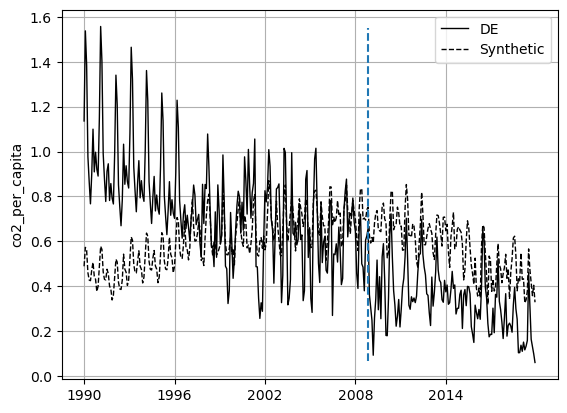

In [71]:
# Monthly synthetic control plot

synth_mo.path_plot(time_period=years, treatment_time='2009-01-01')

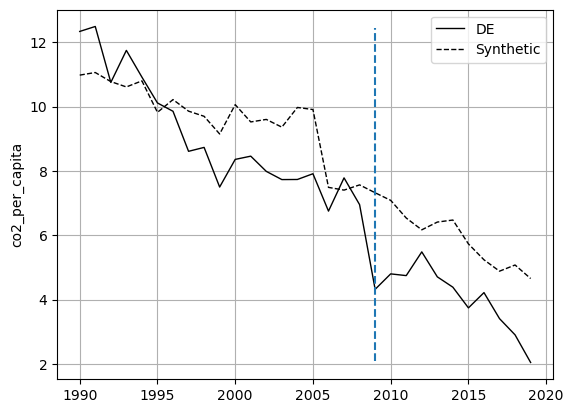

In [72]:
# Yearly synthetic control plot

synth_yr.path_plot_orig(time_period=range(1990,2020), treatment_time=2009)

The summary function give more information on the predictor values. The first column shows the value of the $V$ matrix for each predictor, the column 'treated' shows the mean value of each predictor for the treated unit over the time period `time_predictors_prior`, the column 'synthetic' shows the mean value of each predictor for the synthetic control over the time period `time_predictors_prior` and finally the column 'sample mean' shows the sample mean of that predictor for all control units over the time period `time_predictors_prior` i.e. this is the same as the synthetic control with all weights equal.

In [73]:
synth_mo.summary()

,V,treated,synthetic,sample mean
special.1.eprod_per_capita,0.200,0.000,0.014,0.062
special.2.eflow_per_capita,0.199,-0.030,-0.013,0.029
special.3.snow,0.204,0.800,0.906,1.703
special.4.prcp,0.199,3.840,3.076,2.755
special.5.gdp_per_capita,0.199,0.006,0.005,0.004


In [74]:
synth_yr.summary()

,V,treated,synthetic,sample mean
special.1.yearly_population,0.001,781041.800,6000479.730,5257253.014
special.2.eprod_per_capita,0.772,0.003,0.071,0.754
special.3.eflow_per_capita,0.217,-0.355,-0.236,0.365
special.4.snow,0.004,0.861,1.083,1.715
special.5.prcp,0.002,3.930,1.574,2.772
special.6.tavg,0.001,57.163,59.559,56.006
special.7.gdp_per_capita,0.004,0.078,0.057,0.046


## RGGI State Synthetic Control Comparisons

First, we compare the RGGI synthetic controls at the monthly level.

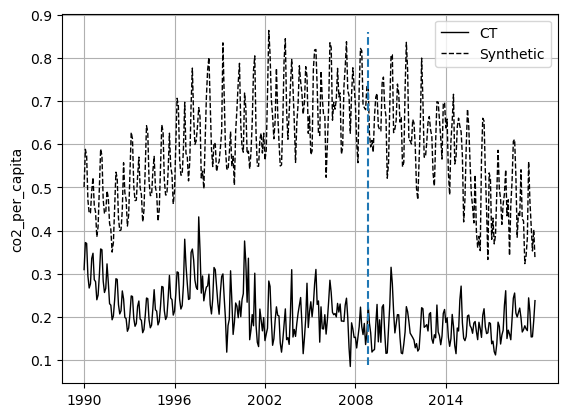

State: CT 

IL    0.902
MN    0.098
Name: weights, dtype: float64 

                              V  treated  synthetic  sample mean
eprod_per_capita          0.308    0.004      0.012        0.066
eflow_per_capita          0.096   -0.016     -0.015        0.033
special.1.snow            0.076    2.519      1.556        1.703
special.2.prcp            0.334    3.634      3.030        2.755
special.3.gdp_per_capita  0.186    0.006      0.005        0.004


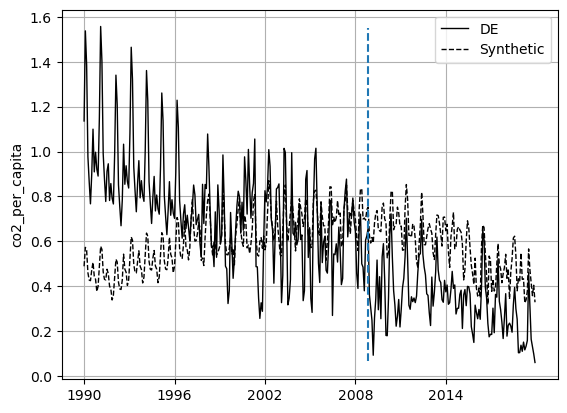

State: DE 

IL    1.0
Name: weights, dtype: float64 

                              V  treated  synthetic  sample mean
eprod_per_capita          0.202    0.000      0.013        0.066
eflow_per_capita          0.201   -0.029     -0.014        0.033
special.1.snow            0.197    0.800      0.906        1.703
special.2.prcp            0.202    3.840      3.076        2.755
special.3.gdp_per_capita  0.197    0.006      0.005        0.004


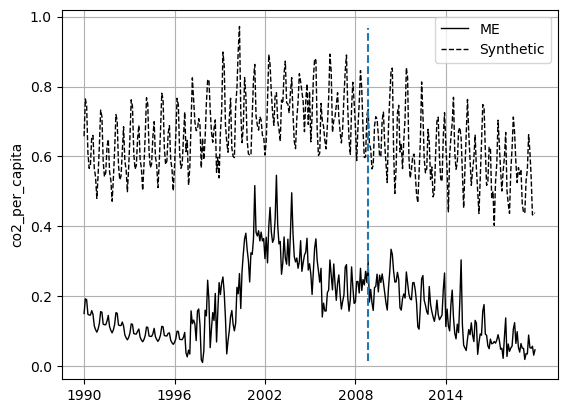

State: ME 

LA    0.222
MN    0.658
MS    0.119
Name: weights, dtype: float64 

                              V  treated  synthetic  sample mean
eprod_per_capita          0.288    0.008      0.015        0.066
eflow_per_capita          0.278   -0.019     -0.025        0.033
special.1.snow            0.184    5.544      4.975        1.703
special.2.prcp            0.238    3.958      3.402        2.755
special.3.gdp_per_capita  0.012    0.004      0.004        0.004


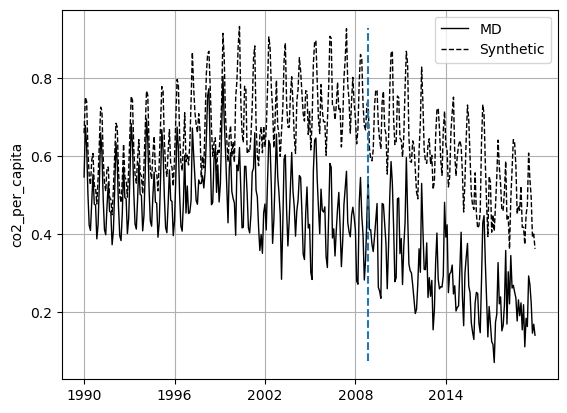

State: MD 

FL    0.070
GA    0.175
IL    0.510
LA    0.115
MN    0.130
Name: weights, dtype: float64 

                              V  treated  synthetic  sample mean
eprod_per_capita          0.186    0.004      0.014        0.066
eflow_per_capita          0.226   -0.018     -0.019        0.033
special.1.snow            0.186    1.467      1.465        1.703
special.2.prcp            0.201    3.534      3.521        2.755
special.3.gdp_per_capita  0.201    0.004      0.004        0.004


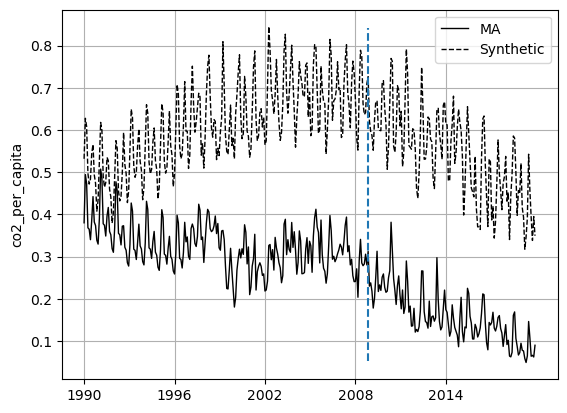

State: MA 

IL    0.645
MN    0.355
Name: weights, dtype: float64 

                              V  treated  synthetic  sample mean
eprod_per_capita          0.217    0.001      0.010        0.066
eflow_per_capita          0.236   -0.018     -0.018        0.033
special.1.snow            0.079    3.959      3.263        1.703
special.2.prcp            0.200    3.641      2.911        2.755
special.3.gdp_per_capita  0.268    0.005      0.005        0.004


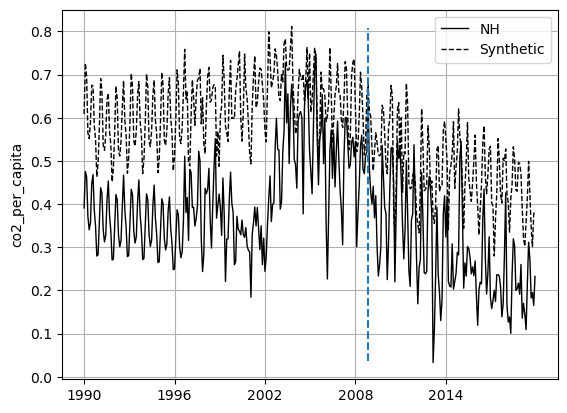

State: NH 

MN    1.0
Name: weights, dtype: float64 

                              V  treated  synthetic  sample mean
eprod_per_capita          0.206    0.008      0.004        0.066
eflow_per_capita          0.198   -0.012     -0.025        0.033
special.1.snow            0.198   22.829      7.550        1.703
special.2.prcp            0.198    7.918      2.610        2.755
special.3.gdp_per_capita  0.199    0.004      0.005        0.004


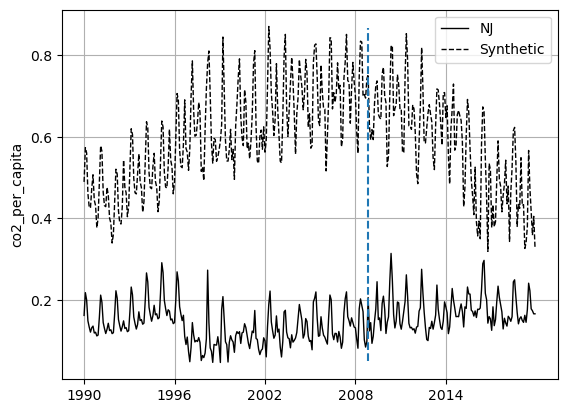

State: NJ 

IL    1.0
Name: weights, dtype: float64 

                              V  treated  synthetic  sample mean
eprod_per_capita          0.204    0.003      0.013        0.066
eflow_per_capita          0.200   -0.022     -0.014        0.033
special.1.snow            0.173    1.071      0.906        1.703
special.2.prcp            0.210    3.508      3.076        2.755
special.3.gdp_per_capita  0.213    0.005      0.005        0.004


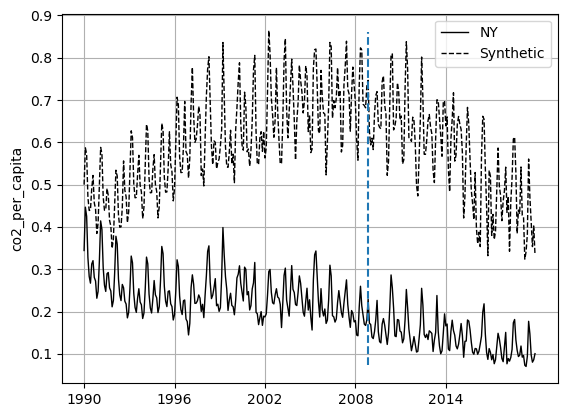

State: NY 

IL    0.911
MN    0.089
Name: weights, dtype: float64 

                              V  treated  synthetic  sample mean
eprod_per_capita          0.254    0.003      0.012        0.066
eflow_per_capita          0.190   -0.014     -0.015        0.033
special.1.snow            0.118    1.920      1.496        1.703
special.2.prcp            0.255    3.532      3.034        2.755
special.3.gdp_per_capita  0.183    0.005      0.005        0.004


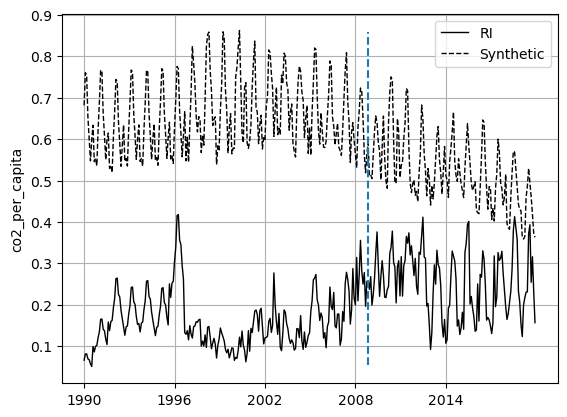

State: RI 

FL    0.576
LA    0.073
MN    0.349
Name: weights, dtype: float64 

                              V  treated  synthetic  sample mean
eprod_per_capita          0.144    0.000      0.007        0.066
eflow_per_capita          0.255   -0.016     -0.020        0.033
special.1.snow            0.211    2.640      2.638        1.703
special.2.prcp            0.097    3.890      3.874        2.755
special.3.gdp_per_capita  0.293    0.004      0.004        0.004


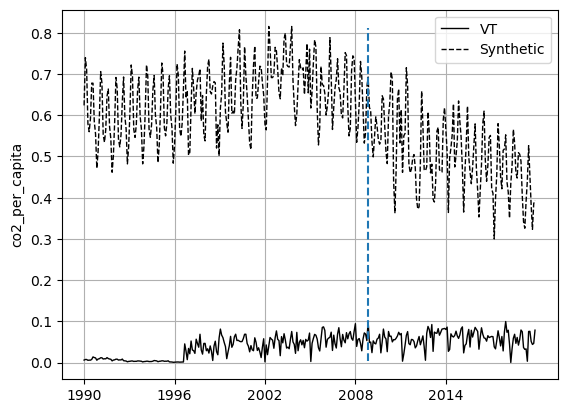

State: VT 

LA    0.062
MN    0.938
Name: weights, dtype: float64 

                              V  treated  synthetic  sample mean
eprod_per_capita          0.131    0.008      0.007        0.066
eflow_per_capita          0.303   -0.012     -0.025        0.033
special.1.snow            0.296    7.324      7.078        1.703
special.2.prcp            0.267    3.078      2.768        2.755
special.3.gdp_per_capita  0.002    0.004      0.005        0.004


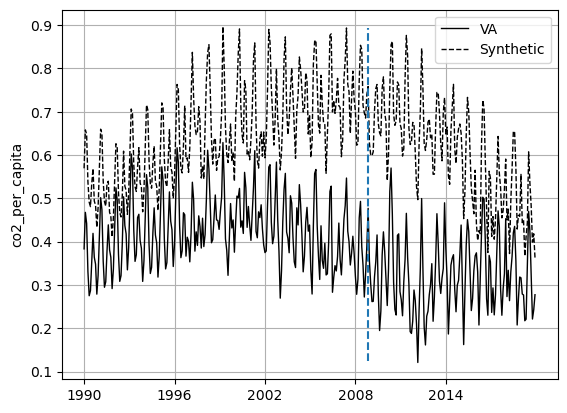

State: VA 

FL    0.050
IL    0.705
LA    0.107
MN    0.036
NC    0.043
PA    0.011
TN    0.012
WA    0.017
Name: weights, dtype: float64 

                              V  treated  synthetic  sample mean
eprod_per_capita          0.197    0.015      0.017        0.066
eflow_per_capita          0.167   -0.013     -0.015        0.033
special.1.snow            0.200    1.036      1.037        1.703
special.2.prcp            0.214    3.364      3.361        2.755
special.3.gdp_per_capita  0.223    0.005      0.005        0.004


In [75]:
# loop through all RGGI states to see their monthly graphs

for state in rggi_states:
    dataprep_mo = Dataprep(
    foo=df_mo,
    predictors=['eprod_per_capita', 'eflow_per_capita'], 
    predictors_op="mean",
    time_predictors_prior=preintervention_feature_range,
    special_predictors=[
        ("snow", preintervention_weather_range, "mean"),
        ('prcp', preintervention_weather_range, "mean"),
        ('gdp_per_capita', preintervention_gdp_range, "mean")
    ],
    dependent="co2_per_capita",
    unit_variable="state",
    time_variable="date",
    treatment_identifier=state,
    controls_identifier= non_rggi_controls_identifier,
    time_optimize_ssr=preintervention_time_range
    )

    # monthly version

    synth_mo = Synth()
    synth_mo.fit(dataprep=dataprep_mo)

    synth_mo.path_plot(time_period=years, treatment_time='2009-01-01')

    print('State:', state,'\n')
    print(synth_mo.weights(threshold=.01),'\n')
    print(synth_mo.summary())
    